In [1]:
# Import libraries

import numpy as np
import torch
from torchvision import datasets
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:

# Loading MNIST dataset

batch_size = 64

# get datasets
dataset = MNIST(root='data/', download=True)
train_data = MNIST(root='data', train=True, transform=ToTensor()) # 60000 images
test_data = MNIST(root='data/', train=False, transform=ToTensor()) # 10000 images

#prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0)


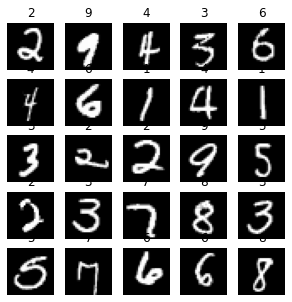

In [6]:

# Visualizing the data

labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}

figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [7]:

# Define discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
 
        # define layers: 3 hidden layers and 1 fully-connected layer: 512, 256, 128, 1
        self.l1=nn.Linear(input_size,hidden_dim*4) 
        self.l2=nn.Linear(hidden_dim*4,hidden_dim*2)
        self.l3=nn.Linear(hidden_dim*2,hidden_dim)
        self.l4=nn.Linear(hidden_dim,output_size)
        
        self.dropout=nn.Dropout(0.3)
    
    def forward(self, x):
        # turn (1, 28, 28) image tensor to (784)
        x=x.view(-1,28*28)
        
        # pass x through all layers apply leaky relu activation to all hidden layers
        hidden_model = nn.LeakyReLU(0.2)

        x = hidden_model(self.l1(x))
        x=self.dropout(x)
        x = hidden_model(self.l2(x))
        x=self.dropout(x)
        x = hidden_model(self.l3(x))
        x=self.dropout(x)
 
        output=self.l4(x)
        return output


In [9]:

# Define generator

class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
 
        # define all layers: 3 hidden layers and 1 fully-connected layer: 128, 256, 512, 784
        self.l1=nn.Linear(input_size,hidden_dim)
        self.l2=nn.Linear(hidden_dim,hidden_dim*2)
        self.l3=nn.Linear(hidden_dim*2,hidden_dim*4)
        self.l4=nn.Linear(hidden_dim*4,output_size)

        self.dropout=nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers and final layer should have tanh applied
        hidden_model = nn.LeakyReLU(0.2)

        x = hidden_model(self.l1(x))
        x=self.dropout(x)
        x = hidden_model(self.l2(x))
        x=self.dropout(x)
        x = hidden_model(self.l3(x))
        x=self.dropout(x)
        
        output=torch.tanh(self.l4(x)) 
        return output


In [11]:

# Hyperparameters

# Discriminator hyperparams
input_size = 784
d_hidden_size = 128
d_output_size = 1

# Generator hyperparams

z_noise = 100
g_hidden_size = 128
g_output_size = 784


In [12]:

# Build model

# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_noise, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)


Discriminator(
  (l1): Linear(in_features=784, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (l1): Linear(in_features=100, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=512, bias=True)
  (l4): Linear(in_features=512, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [13]:

# Loss

def real_loss(D_out, smooth=False):
    # compare logits to real labels smooth labels if smooth=True
    batch_size=D_out.size(0)
    if smooth:
        labels=torch.ones(batch_size)*0.9
    else:
        labels=torch.ones(batch_size)
        
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size=D_out.size(0)
    labels=torch.zeros(batch_size) #to create fake labels
        
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [14]:

# Optimizer

# learning rate for optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(),lr)
g_optimizer = optim.Adam(G.parameters(),lr)


In [18]:

# Training

num_epochs = 20
samples = []
losses = []
print_every = 400
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_noise))
fixed_z = torch.from_numpy(fixed_z).float()
D.train()
G.train()
for epoch in range(num_epochs):
   for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images*2 -1
        d_optimizer.zero_grad()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
 
        z = np.random.uniform(-1, 1, size=(batch_size, z_noise))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
 
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
 
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
 
        g_optimizer.zero_grad()
 
        z = np.random.uniform(-1, 1, size=(batch_size, z_noise))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) 
        g_loss.backward()
        g_optimizer.step()
        if batch_i % print_every == 0:
             print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss:  {:6.4f}'.format(epoch+1, num_epochs,  
                    d_loss.item(), g_loss.item()))
## AFTER EACH EPOCH##
   losses.append((d_loss.item(), g_loss.item()))
   G.eval() 
   samples_z = G(fixed_z)
   samples.append(samples_z)
   G.train()
with open('train_samples.pkl', 'wb') as f:
   pkl.dump(samples, f)


Epoch [    1/   20] | d_loss: 1.3259 | g_loss:  0.7221
Epoch [    1/   20] | d_loss: 0.7220 | g_loss:  3.8682
Epoch [    1/   20] | d_loss: 0.7505 | g_loss:  2.9521
Epoch [    2/   20] | d_loss: 0.4857 | g_loss:  3.7420
Epoch [    2/   20] | d_loss: 0.5290 | g_loss:  4.9567
Epoch [    2/   20] | d_loss: 0.5527 | g_loss:  4.0063
Epoch [    3/   20] | d_loss: 0.5513 | g_loss:  5.3547
Epoch [    3/   20] | d_loss: 0.4595 | g_loss:  5.0264
Epoch [    3/   20] | d_loss: 0.5300 | g_loss:  4.8369
Epoch [    4/   20] | d_loss: 0.5412 | g_loss:  3.9461
Epoch [    4/   20] | d_loss: 0.6962 | g_loss:  4.7850
Epoch [    4/   20] | d_loss: 0.5968 | g_loss:  3.6542
Epoch [    5/   20] | d_loss: 0.6246 | g_loss:  3.5976
Epoch [    5/   20] | d_loss: 0.6564 | g_loss:  3.2962
Epoch [    5/   20] | d_loss: 0.6684 | g_loss:  2.2543
Epoch [    6/   20] | d_loss: 0.7014 | g_loss:  2.4252
Epoch [    6/   20] | d_loss: 0.7343 | g_loss:  1.8974
Epoch [    6/   20] | d_loss: 0.8172 | g_loss:  3.3568
Epoch [   